# Imports und Umgebungsvariablen

In [24]:
import pandas as pd
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta

fake = Faker('de_DE')
np.random.seed(42)
random.seed(42)

# Sonstige Variablen

In [2]:
anteil_vegetarier = 0.2 # Anteil Vegetarier in Prozent

# Daten generieren

## Vorlesungen
Die Vorlesungen sollen aus den realen rapla Daten gelesen werden.
Mehr dazu: https://github.com/HendrikMeyer02/calender-data/

### Daten einlesen

In [3]:
df_vorlesungen = pd.read_csv("dhbw_kalender.csv", encoding='utf-8')


df_vorlesungen['summary'] = df_vorlesungen['summary'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()


In [4]:
df_vorlesungen.head()

,summary,description,location,uid,start_date,start_time,start_datetime,end_date,end_time,end_datetime,created,last_modified,status,organizer,Kurs
0,Tag der Arbeit,NaN,XOnline-Veranstaltung wird verschoben unter Vi...,26064,2023-05-01,08:00:00,2023-05-01 08:00:00+02:00,2023-05-01,18:00:00,2023-05-01 18:00:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
1,Christi Himmelfahrt,NaN,NaN,27491,2023-05-18,08:00:00,2023-05-18 08:00:00+02:00,2023-05-18,18:00:00,2023-05-18 18:00:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
2,Pfingstmontag,NaN,NaN,28115,2023-05-29,08:00:00,2023-05-29 08:00:00+02:00,2023-05-29,18:00:00,2023-05-29 18:00:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
3,Mathematik-Analysis,NaN,A262 Hörsaal,38145,2023-06-02,08:00:00,2023-06-02 08:00:00+02:00,2023-06-02,12:15:00,2023-06-02 12:15:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
4,"Routing and Switching (CCNA-2, Z)",NaN,"A262 Hörsaal, E309 Labor",35913,2023-06-02,13:00:00,2023-06-02 13:00:00+02:00,2023-06-02,15:30:00,2023-06-02 15:30:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1


### Daten filtern

In [5]:
ausschluss_begriffe = ["Feiertag", "Klausur", "Sonstiger Termin", "Prüfung", "Vorlesungsfrei", "Selbststudium"]

# 'title' enthält die beschreibenden Texte
maske = ~df_vorlesungen['summary'].astype(str).str.contains('|'.join(ausschluss_begriffe), case=False, na=False)

df_gefiltert = df_vorlesungen[maske]
# df_gefiltert.head()

### Vorlesungstabelle erstellen

## Kurse

In [6]:
# Eindeutige Kurse extrahieren
kurse_liste = df_vorlesungen['Kurs'].dropna().unique()

# DataFrame erstellen
kurse_df = pd.DataFrame({
    'Kurs': kurse_liste,
    'Anzahl_Studenten': np.random.randint(20, 35, size=len(kurse_liste))  # z. B. 20–40 Studierende
})

# Sortieren (optional, alphabetisch oder nach Kurs_ID)
kurse_df = kurse_df.sort_values('Kurs').reset_index(drop=True)
# kurse_df
kurse_df.head()

,Kurs,Anzahl_Studenten
0,KA-GAGPW24B1,29
1,KA-GTPA22B1,28
2,KA-GTPA22B2,31
3,KA-GWAG22B1,32
4,KA-GWAG23B1,21


## Studenten

### Variablen

In [7]:
# Wahrscheinlichkeit, dass ein Nachschlag geholt wird
nachschlag_Maenner = 0.3
nachschlag_Frauen = 0.15

In [8]:
studenten = []
m_nr_counter = 10000

for _, row in kurse_df.iterrows():
    kurs = row['Kurs']
    anzahl = row['Anzahl_Studenten']
    
    for _ in range(anzahl):
        geschlecht = random.choice(['m', 'w'])
        vegetarier = random.random() < anteil_vegetarier
        beilage = np.random.dirichlet([1, 1])  # Summe = 1
        nachschlag = np.clip(np.random.normal(nachschlag_Maenner if geschlecht == 'm' else nachschlag_Frauen, 0.1), 0, 1)

        studenten.append({
            'M_nr': m_nr_counter,
            'Kurs': kurs,
            'Geschlecht': geschlecht,
            'Vegetarier': vegetarier,
            'Obst': beilage[0],
            'Salat': beilage[1],
            'Nachschlag': round(nachschlag, 2)
        })
        m_nr_counter += 1

studenten_df = pd.DataFrame(studenten)
# studenten_df.head()

### Wie oft der Student die Mensa besucht

#### Variablen

In [9]:
mittelwert_maenner = 0.85  # Männer essen im Mittel öfter in der Mensa
mittelwert_frauen = 0.75   # Frauen etwas weniger
std_abw = 0.3              # Standardabweichung (Geschlechterunspezifisch)

mittelwert_faktor_reduzierung_1 = 0.4 # Nur eine Vorlesung am Tag
mittelwert_faktor_reduzierung_2 = 0.2 # Keine Vorlesung am Tag
faktor_std_abw = 0.2                  # Standardabweichung

# Leeres Array für die Wahrscheinlichkeiten
mensa_wahrscheinlichkeit = np.zeros(len(studenten_df))

#### Berechnen der generellen Wahrscheinlichkeit für einen Mensabesuch
Diese Wahrscheinlichkeit gilt für den Fall, dass Vor- und Nachmittags Vorlesungen stattfinden. Falls dies nicht der Fall sein sollte wird der Wert verändert.

In [10]:
# Indexe nach Geschlecht
idx_maenner = studenten_df['Geschlecht'] == 'm'
idx_frauen = studenten_df['Geschlecht'] == 'w'

# Zufallswerte für Männer
mensa_wahrscheinlichkeit[idx_maenner] = np.random.normal(
    loc=mittelwert_maenner, scale=std_abw, size=idx_maenner.sum())

# Zufallswerte für Frauen
mensa_wahrscheinlichkeit[idx_frauen] = np.random.normal(
    loc=mittelwert_frauen, scale=std_abw, size=idx_frauen.sum())

# Wahrscheinlichkeiten auf [0,1] beschränken
mensa_wahrscheinlichkeit = np.clip(mensa_wahrscheinlichkeit, 0, 1)

# Zu DataFrame hinzufügen
studenten_df['Mensa_Wahrscheinlichkeit'] = np.round(mensa_wahrscheinlichkeit, 2)

studenten_df.head()

,M_nr,Kurs,Geschlecht,Vegetarier,Obst,Salat,Nachschlag,Mensa_Wahrscheinlichkeit
0,10000,KA-GAGPW24B1,m,True,0.837421,0.162579,0.36,1.00
1,10001,KA-GAGPW24B1,w,False,0.469515,0.530485,0.24,0.81
2,10002,KA-GAGPW24B1,m,False,0.147707,0.852293,0.15,0.70
3,10003,KA-GAGPW24B1,m,False,0.149874,0.850126,0.41,0.63
4,10004,KA-GAGPW24B1,m,True,0.231199,0.768801,0.38,1.00


#### Berechnen der speziellen Wahrscheinlichkeit für einen Mensabesuch
Diese Wahrscheinlichkeit gilt für den Fall, dass
1) nur eine Vorlesung stattfindet "mensa_wahrsch_reduziert"
2) keine Vorlesung stattfindet "mensa_wahrsch_reduziert_2".

In [11]:
# Reduktionsfaktor bei nur einer Vorlesung (z. B. Vormittag oder Nachmittag)
reduzierungsfaktor_1 = np.clip(
    np.random.normal(mittelwert_faktor_reduzierung_1, faktor_std_abw, size=len(studenten_df)), 0, 1
)

# Reduktionsfaktor bei keiner Vorlesung
reduzierungsfaktor_2 = np.clip(
    np.random.normal(mittelwert_faktor_reduzierung_2, faktor_std_abw, size=len(studenten_df)), 0, 1
)

# Neue Spalten mit reduzierten Wahrscheinlichkeiten
studenten_df['mensa_wahrsch_reduziert'] = np.round(
    studenten_df['Mensa_Wahrscheinlichkeit'] * reduzierungsfaktor_1, 2
)

studenten_df['mensa_wahrsch_reduziert_2'] = np.round(
    studenten_df['Mensa_Wahrscheinlichkeit'] * reduzierungsfaktor_2, 2
)

studenten_df.head()

,M_nr,Kurs,Geschlecht,Vegetarier,Obst,Salat,Nachschlag,Mensa_Wahrscheinlichkeit,mensa_wahrsch_reduziert,mensa_wahrsch_reduziert_2
0,10000,KA-GAGPW24B1,m,True,0.837421,0.162579,0.36,1.00,0.50,0.00
1,10001,KA-GAGPW24B1,w,False,0.469515,0.530485,0.24,0.81,0.43,0.21
2,10002,KA-GAGPW24B1,m,False,0.147707,0.852293,0.15,0.70,0.20,0.13
3,10003,KA-GAGPW24B1,m,False,0.149874,0.850126,0.41,0.63,0.11,0.00
4,10004,KA-GAGPW24B1,m,True,0.231199,0.768801,0.38,1.00,0.42,0.52


# Daten visualisieren

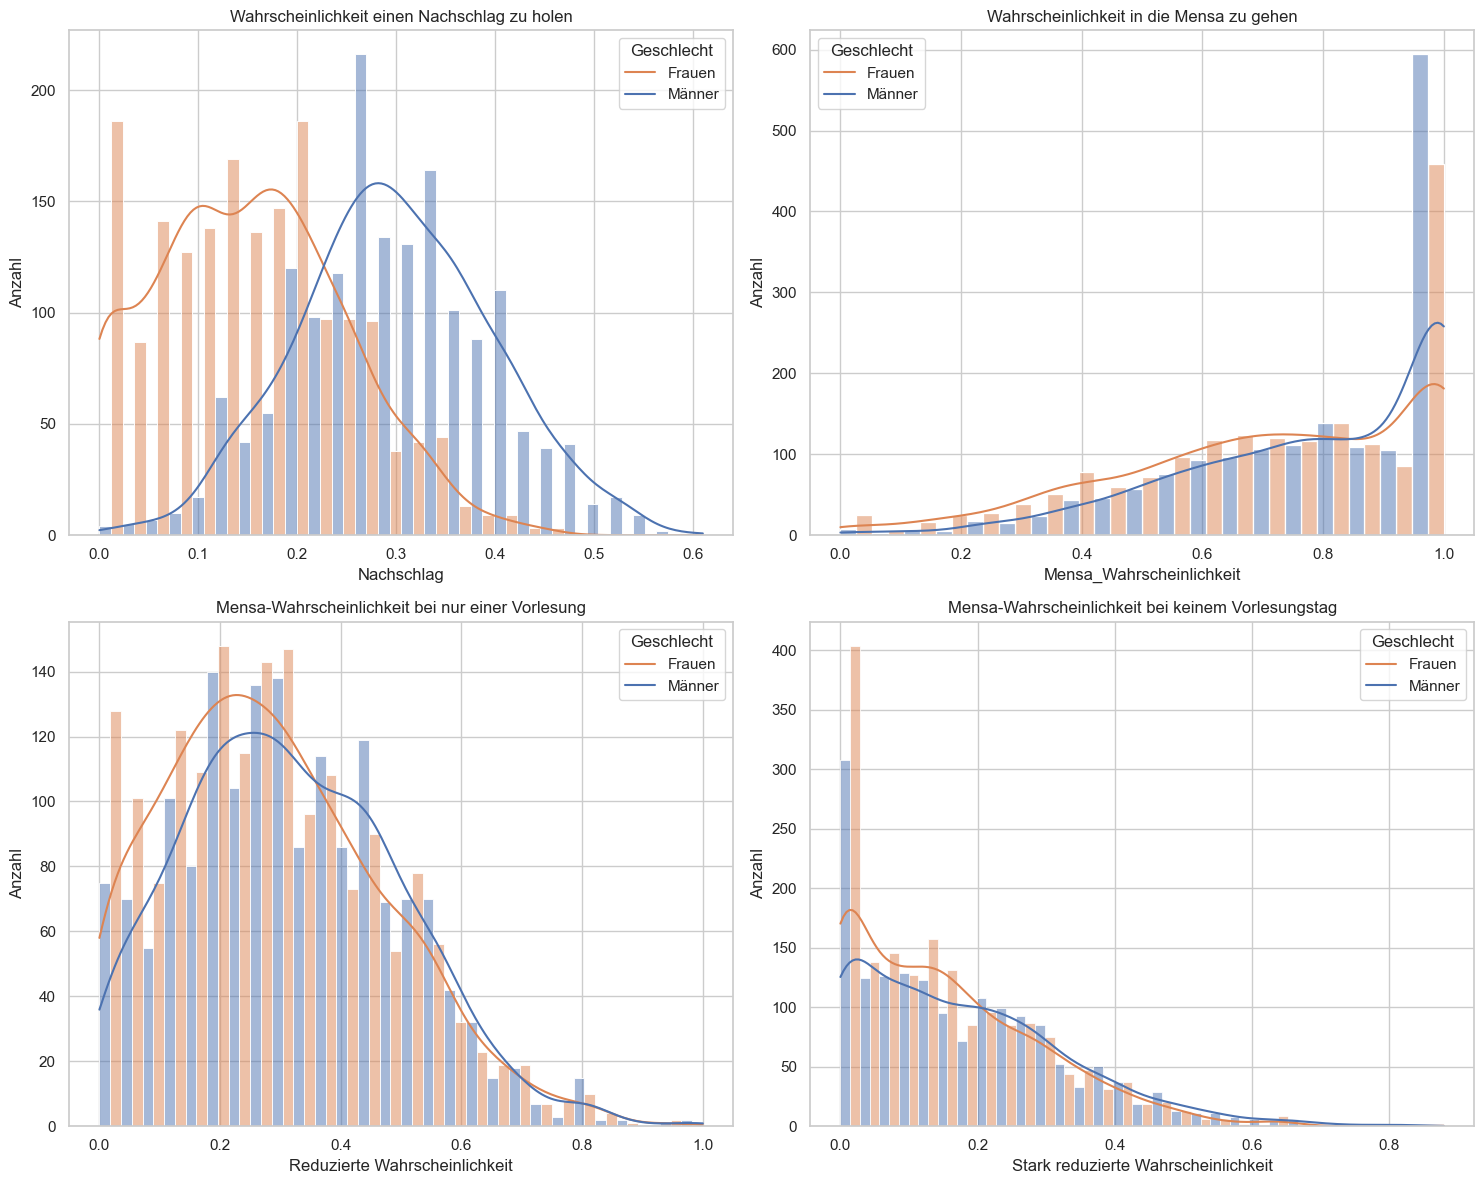

In [12]:
# Set the style for better visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# Create a subplot layout
plt.subplot(2, 2, 1)
# Visualize the distribution of Nachschlag by gender
sns.histplot(data=studenten_df, x="Nachschlag", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Wahrscheinlichkeit einen Nachschlag zu holen")
plt.xlabel("Nachschlag")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

plt.subplot(2, 2, 2)
# Visualize the distribution of Mensa_Wahrscheinlichkeit by gender
sns.histplot(data=studenten_df, x="Mensa_Wahrscheinlichkeit", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Wahrscheinlichkeit in die Mensa zu gehen")
plt.xlabel("Mensa_Wahrscheinlichkeit")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

# Subplot 3 – Reduziert bei nur einer Vorlesung
plt.subplot(2, 2, 3)
sns.histplot(data=studenten_df, x="mensa_wahrsch_reduziert", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Mensa-Wahrscheinlichkeit bei nur einer Vorlesung")
plt.xlabel("Reduzierte Wahrscheinlichkeit")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

# Subplot 4 – Reduziert bei keiner Vorlesung
plt.subplot(2, 2, 4)
sns.histplot(data=studenten_df, x="mensa_wahrsch_reduziert_2", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Mensa-Wahrscheinlichkeit bei keinem Vorlesungstag")
plt.xlabel("Stark reduzierte Wahrscheinlichkeit")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

plt.tight_layout()
plt.show()

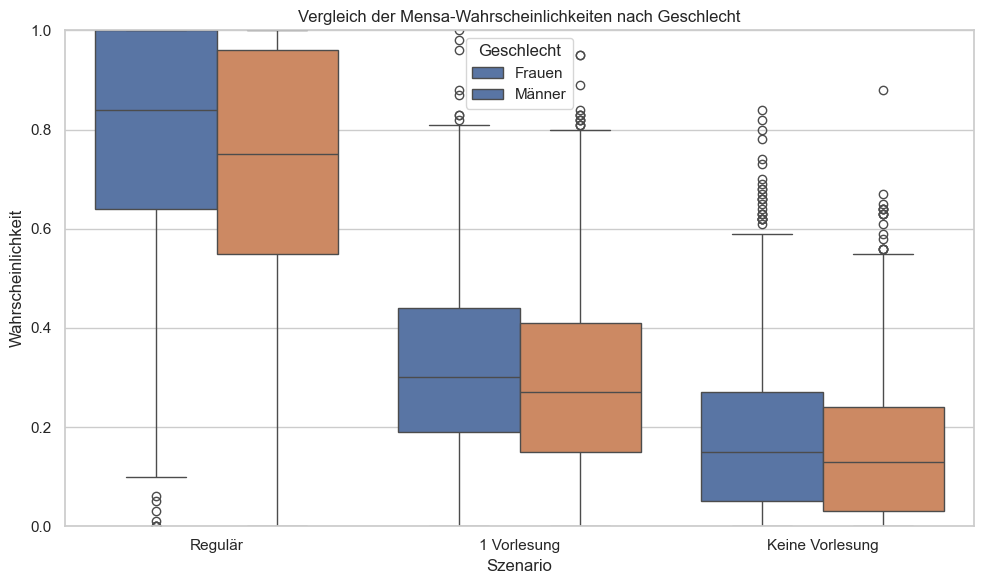

In [13]:
# Zunächst Daten umstrukturieren (Wide → Long Format)
wahrscheinlichkeiten_df = studenten_df.melt(
    id_vars="Geschlecht",
    value_vars=[
        "Mensa_Wahrscheinlichkeit",
        "mensa_wahrsch_reduziert",
        "mensa_wahrsch_reduziert_2"
    ],
    var_name="Typ",
    value_name="Wahrscheinlichkeit"
)

# Optional: besser lesbare Bezeichnungen
typ_labels = {
    "Mensa_Wahrscheinlichkeit": "Regulär",
    "mensa_wahrsch_reduziert": "1 Vorlesung",
    "mensa_wahrsch_reduziert_2": "Keine Vorlesung"
}
wahrscheinlichkeiten_df["Typ"] = wahrscheinlichkeiten_df["Typ"].map(typ_labels)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=wahrscheinlichkeiten_df, x="Typ", y="Wahrscheinlichkeit", hue="Geschlecht")
plt.title("Vergleich der Mensa-Wahrscheinlichkeiten nach Geschlecht")
plt.xlabel("Szenario")
plt.ylabel("Wahrscheinlichkeit")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Daten exportieren

In [14]:
studenten_df.to_csv('studenten_df.csv', index=False)
studenten_df.head()

,M_nr,Kurs,Geschlecht,Vegetarier,Obst,Salat,Nachschlag,Mensa_Wahrscheinlichkeit,mensa_wahrsch_reduziert,mensa_wahrsch_reduziert_2
0,10000,KA-GAGPW24B1,m,True,0.837421,0.162579,0.36,1.00,0.50,0.00
1,10001,KA-GAGPW24B1,w,False,0.469515,0.530485,0.24,0.81,0.43,0.21
2,10002,KA-GAGPW24B1,m,False,0.147707,0.852293,0.15,0.70,0.20,0.13
3,10003,KA-GAGPW24B1,m,False,0.149874,0.850126,0.41,0.63,0.11,0.00
4,10004,KA-GAGPW24B1,m,True,0.231199,0.768801,0.38,1.00,0.42,0.52


# Studenten in der Mensa pro Tag
## Mensa-Belegung berechnen
Nimm die Daten der Vorlesungstabelle und der Studententabelle und berechne daraus, wie viele Studenten an diesem Tag in der Mensa sein werden.

In [17]:
print(df_gefiltert.columns)

Index(['summary', 'description', 'location', 'uid', 'start_date', 'start_time',
       'start_datetime', 'end_date', 'end_time', 'end_datetime', 'created',
       'last_modified', 'status', 'organizer', 'Kurs'],
      dtype='object')


In [30]:
df_gefiltert = df_gefiltert.copy()

# Stelle sicher, dass Datum als datetime erkannt wird
df_gefiltert['start_date'] = pd.to_datetime(df_gefiltert['start_date'])

# Alle vorhandenen Tage im Vorlesungsplan
alle_daten = pd.to_datetime(df_gefiltert['start_date']).dt.date.dropna().sort_values().unique()

# Leeres Dictionary für die Ergebnisse
mensa_besucher_pro_tag = {}

# Durch alle Tage iterieren
for datum in alle_daten:
    kurse_an_diesem_tag = df_gefiltert[df_gefiltert['start_date'].dt.date == datum]
    
    # Für jeden Kurs an dem Tag bestimmen, wie viele Blöcke (Vor-/Nachmittag) er hat
    kurs_blöcke = defaultdict(int)
    for _, row in kurse_an_diesem_tag.iterrows():
        kurs = row['Kurs']
        if pd.notna(kurs):
            kurs_blöcke[kurs] += 1  # jede Zeile zählt als Block

    anzahl_in_mensa = 0

    # Für jeden Kurs alle zugehörigen Studierenden durchgehen
    for kurs, anzahl_bloecke in kurs_blöcke.items():
        studenten = studenten_df[studenten_df['Kurs'] == kurs]

        for _, student in studenten.iterrows():
            if anzahl_bloecke == 0:
                wahrscheinlichkeit = student['mensa_wahrsch_reduziert_2']
            elif anzahl_bloecke == 1:
                wahrscheinlichkeit = student['mensa_wahrsch_reduziert']
            else:
                wahrscheinlichkeit = student['Mensa_Wahrscheinlichkeit']

            if np.random.rand() < wahrscheinlichkeit:
                anzahl_in_mensa += 1

    mensa_besucher_pro_tag[pd.to_datetime(datum).date()] = anzahl_in_mensa

# Ausgabe als DataFrame
mensa_df = pd.DataFrame(list(mensa_besucher_pro_tag.items()), columns=["Datum", "Anzahl_Studierende_Mensa"])
mensa_df = mensa_df.sort_values("Datum")

,Datum,Anzahl_Studierende_Mensa
0,2023-04-28,19
1,2023-05-01,52
2,2023-05-02,28
3,2023-05-03,10
4,2023-05-04,24
...,...,...
693,2025-09-08,102
694,2025-09-09,137
695,2025-09-10,108
696,2025-09-11,147


## Belegung als Grafik

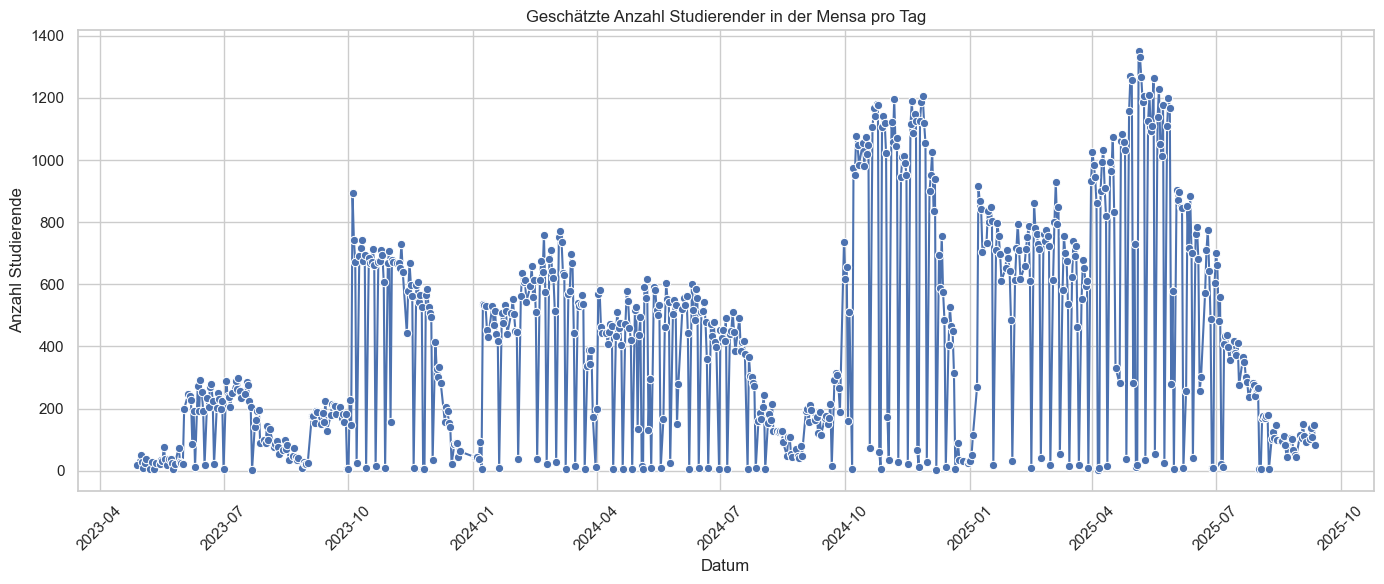

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Liniendiagramm: Anzahl Studierende in der Mensa pro Tag
sns.lineplot(data=mensa_df, x="Datum", y="Anzahl_Studierende_Mensa", marker="o")

plt.title("Geschätzte Anzahl Studierender in der Mensa pro Tag")
plt.xlabel("Datum")
plt.ylabel("Anzahl Studierende")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()